# Text Classification:

## Data
<pre>
1. we have total of 20 types of documents(Text files) and total 18828 documents(text files).
2. You can download data from this <a href='https://drive.google.com/open?id=1rxD15nyeIPIAZ-J2VYPrDRZI66-TBWvM'>link</a>, in that you will get documents.rar folder. <br>If you unzip that, you will get total of 18828 documnets. document name is defined as'ClassLabel_DocumentNumberInThatLabel'. 
so from document name, you can extract the label for that document.
4. Now our problem is to classify all the documents into any one of the class.
5. Below we provided count plot of all the labels in our data. 
</pre>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import re
import seaborn as sns
import pandas as pd
import numpy as np
import os
import pickle
from tqdm import tqdm

from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.chunk import tree2conlltags

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input,Dense,Conv1D,concatenate,Embedding,Flatten,Dropout,BatchNormalization,MaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import datetime

In [2]:
Class_Label = []
Text = []
Document_Name = []

for i in tqdm(os.listdir(r'C:\Users\SVF\OneDrive\Documents\documents')):
    data = []
    Document_Name.append(i)
    l = i.split('_')[0]
    Class_Label.append(l) # Storing class labels
    
    # data contains all the contents of the file
    with open(r'C:\Users\SVF\OneDrive\Documents\documents/'+ i,'r',encoding='utf8', errors='replace') as f:
        data.append(f.read())
    Text.append(data)
    

100%|███████████████████████████████████████████████████████████████████████████| 18828/18828 [01:24<00:00, 223.55it/s]


In [3]:
len(Class_Label)

18828

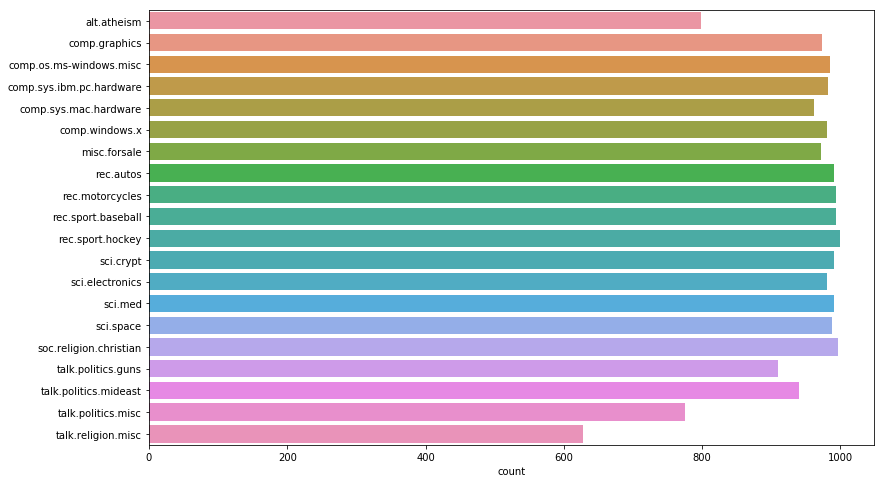

In [4]:
### count plot of all the class labels. 
plt.figure(figsize=(13,8))
sns.countplot(y = Class_Label)
plt.show()

In [5]:
df = pd.DataFrame({'Text': Text, 'Labels': Class_Label})

In [6]:
df.sample(5)

,Text,Labels
16544,[From: mau@herky.cs.uiowa.edu (Mau Napoleon)\n...,talk.politics.mideast
4927,[From: ianhogg@milli.cs.umn.edu (Ian J. Hogg)\...,comp.windows.x
99,[Subject: Re: A visit from the Jehovah's Witne...,alt.atheism
13517,[From: calzone@athena.mit.edu\nSubject: Legali...,sci.med
13505,[From: banschbach@vms.ocom.okstate.edu\nSubjec...,sci.med


## Assignment:

#### sample document
<pre>
<font color='blue'>
Subject: A word of advice
From: jcopelan@nyx.cs.du.edu (The One and Only)

In article < 65882@mimsy.umd.edu > mangoe@cs.umd.edu (Charley Wingate) writes:
>
>I've said 100 times that there is no "alternative" that should think you
>might have caught on by now.  And there is no "alternative", but the point
>is, "rationality" isn't an alternative either.  The problems of metaphysical
>and religious knowledge are unsolvable-- or I should say, humans cannot
>solve them.

How does that saying go: Those who say it can't be done shouldn't interrupt
those who are doing it.

Jim
--
Have you washed your brain today?
</font>
</pre>

### Preprocessing:
<pre>
useful links: <a href='http://www.pyregex.com/'>http://www.pyregex.com/</a>

<font color='blue'><b>1.</b></font> Find all emails in the document and then get the text after the "@". and then split those texts by '.' 
after that remove the words whose length is less than or equal to 2 and also remove'com' word and then combine those words by space. 
In one doc, if we have 2 or more mails, get all.
<b>Eg:[test@dm1.d.com, test2@dm2.dm3.com]-->[dm1.d.com, dm3.dm4.com]-->[dm1,d,com,dm2,dm3,com]-->[dm1,dm2,dm3]-->"dm1 dm2 dm3" </b> 
append all those into one list/array. ( This will give length of 18828 sentences i.e one list for each of the document). 
Some sample output was shown below. 

> In the above sample document there are emails [jcopelan@nyx.cs.du.edu, 65882@mimsy.umd.edu, mangoe@cs.umd.edu]

preprocessing:
[jcopelan@nyx.cs.du.edu, 65882@mimsy.umd.edu, mangoe@cs.umd.edu] ==> [nyx cs du edu mimsy umd edu cs umd edu] ==> 
[nyx edu mimsy umd edu umd edu]

<font color='blue'><b>2.</b></font> Replace all the emails by space in the original text. 
</pre>

In [ ]:
# we have collected all emails and preprocessed them, this is sample output
preprocessed_email

In [ ]:
len(preprocessed_email)

<pre>
<font color='blue'><b>3.</b></font> Get subject of the text i.e. get the total lines where "Subject:" occur and remove 
the word which are before the ":" remove the newlines, tabs, punctuations, any special chars.
<b>Eg: if we have sentance like "Subject: Re: Gospel Dating @ \r\r\n" --> You have to get "Gospel Dating"</b> 
Save all this data into another list/array. 

<font color='blue'><b>4.</b></font> After you store it in the list, Replace those sentances in original text by space.

<font color='blue'><b>5.</b></font> Delete all the sentances where sentence starts with <b>"Write to:"</b> or <b>"From:"</b>.
> In the above sample document check the 2nd line, we should remove that

<font color='blue'><b>6.</b></font> Delete all the tags like "< anyword >"
> In the above sample document check the 4nd line, we should remove that "< 65882@mimsy.umd.edu >"


<font color='blue'><b>7.</b></font> Delete all the data which are present in the brackets. 
In many text data, we observed that, they maintained the explanation of sentence 
or translation of sentence to another language in brackets so remove all those.
<b>Eg: "AAIC-The course that gets you HIRED(AAIC - Der Kurs, der Sie anstellt)" --> "AAIC-The course that gets you HIRED"</b>

> In the above sample document check the 4nd line, we should remove that "(Charley Wingate)"


<font color='blue'><b>8.</b></font> Remove all the newlines('\n'), tabs('\t'), "-", "\".

<font color='blue'><b>9.</b></font> Remove all the words which ends with <b>":"</b>.
<b>Eg: "Anyword:"</b>
> In the above sample document check the 4nd line, we should remove that "writes:"


<font color='blue'><b>10.</b></font> Decontractions, replace words like below to full words. 
please check the donors choose preprocessing for this 
<b>Eg: can't -> can not, 's -> is, i've -> i have, i'm -> i am, you're -> you are, i'll --> i will </b>

<b> There is no order to do point 6 to 10. but you have to get final output correctly</b>

<font color='blue'><b>11.</b></font> Do chunking on the text you have after above preprocessing. 
Text chunking, also referred to as shallow parsing, is a task that 
follows Part-Of-Speech Tagging and that adds more structure to the sentence.
So it combines the some phrases, named entities into single word.
So after that combine all those phrases/named entities by separating <b>"_"</b>. 
And remove the phrases/named entities if that is a "Person". 
You can use <b>nltk.ne_chunk</b> to get these. 
Below we have given one example. please go through it. 

useful links: 
<a href='https://www.nltk.org/book/ch07.html'>https://www.nltk.org/book/ch07.html</a>
<a href='https://stackoverflow.com/a/31837224/4084039'>https://stackoverflow.com/a/31837224/4084039</a>
<a href='http://www.nltk.org/howto/tree.html'>http://www.nltk.org/howto/tree.html</a>
<a href='https://stackoverflow.com/a/44294377/4084039'>https://stackoverflow.com/a/44294377/4084039</a>
</pre>

In [ ]:
#i am living in the New York
print("i am living in the New York -->", list(chunks))
print(" ")
print("-"*50)
print(" ")
#My name is Srikanth Varma
print("My name is Srikanth Varma -->", list(chunks1))

<pre>We did chunking for above two lines and then We got one list where each word is mapped to a 
POS(parts of speech) and also if you see "New York" and "Srikanth Varma", 
they got combined and represented as a tree and "New York" was referred as "GPE" and "Srikanth Varma" was referred as "PERSON". 
so now you have to Combine the "New York" with <b>"_"</b> i.e "New_York"
and remove the "Srikanth Varma" from the above sentence because it is a person.</pre>

<pre>
<font color='blue'><b>13.</b></font> Replace all the digits with space i.e delete all the digits. 
> In the above sample document, the 6th line have digit 100, so we have to remove that.

<font color='blue'><b>14.</b></font> After doing above points, we observed there might be few word's like
 <b> "_word_" (i.e starting and ending with the _), "_word" (i.e starting with the _),
  "word_" (i.e ending with the _)</b> remove the <b>_</b> from these type of words. 

<font color='blue'><b>15.</b></font>  We also observed some words like <b> "OneLetter_word"- eg: d_berlin, 
"TwoLetters_word" - eg: dr_berlin </b>, in these words we remove the "OneLetter_" (d_berlin ==> berlin) and 
"TwoLetters_" (de_berlin ==> berlin). i.e remove the words 
which are length less than or equal to 2 after spliiting those words by "_". 

<font color='blue'><b>16.</b></font> Convert all the words into lower case and lowe case 
and remove the words which are greater than or equal to 15 or less than or equal to 2.

<font color='blue'><b>17.</b></font> replace all the words except "A-Za-z_" with space. 

<font color='blue'><b>18.</b></font> Now You got Preprocessed Text, email, subject. create a dataframe with those. 
Below are the columns of the df. 
</pre>

In [ ]:
data.columns

In [ ]:
data.iloc[400]

### To get above mentioned data frame --> Try to Write Total Preprocessing steps in One Function Named Preprocess as below. 

In [7]:
def preprocess(Input_Text):
    """Do all the Preprocessing as shown above and
    return a tuple contain preprocess_email,preprocess_subject,preprocess_text for that Text_data"""
    
    # Preprocessing E-mails
    Pre_processed_emails = []
    list_of_preprocessed_email = ' '
    emails = re.findall(r'[\w\.-]+@[\w\.-]+\.\w+', str(Input_Text))
    for e in emails:
        temp_email = e.split("@")[1]
        temp_email = temp_email.split('.')
        temp_email = [em for em in temp_email if len(em) > 2 and em != 'com']
        Pre_processed_emails.extend(temp_email)
    list_of_preprocessed_email =' '.join(Pre_processed_emails)
        
    # Replace all the emails by space in the original text.
    Text = re.sub(r'[\w\.-]+@[\w\.-]+\.\w+', ' ', Input_Text)
    
    # Preprecessing Subject
    subject = re.findall("Subject:.*", Input_Text)
    subject = re.sub(r'(Subject: | [^A-Za-z0-9\s])', '', subject[0])
    
    # Replace subject: by space in the original text.
    Text = re.sub('Subject: ','', Text)
    
    # Delete all the sentances where sentence starts with "Write to:" or "From:".
    Text = re.sub(r'(Write To: | From:).*', '', Text)
    
    # Delete all the tags like "< anyword >"
    Text = re.sub(r'<.*?>', '', Text)
    
    # Delete all the data which are present in the brackets.
    Text = re.sub(r'\(.*\)','',Text)
    
    # Remove all the newlines('\n'), tabs('\t'), "-", "\".
    Text = re.sub(r'[\n\t-]*','', Text)
    
    # Remove all the words which ends with ":".
    Text = re.sub(r'\w+:\s?','', Text)
    
    # Decontractions, replace words like into full words.
    Text = re.sub(r"\'m", " am", Text)
    Text = re.sub(r"\'s", " is", Text)
    Text = re.sub(r"\'re", " are", Text)
    Text = re.sub(r"\'t", " not", Text)
    Text = re.sub(r"\'ll", " will", Text)
    Text = re.sub(r"\'ve", " have", Text)
    Text = re.sub(r"\'d", " would", Text)
    Text = re.sub(r"won't", "will not", Text)
    Text = re.sub(r"can\'t", "can not", Text)
    
    # Do chunking on the text
    # Ref:https://stackoverflow.com/questions/31836058/nltk-named-entity-recognition-to-a-python-list/44294377#44294377 
    chunked = ne_chunk(pos_tag(word_tokenize(Text)))     
    new_chunk = []
    current_chunk = []
    for i in chunked:
        if type(i) == 'Tree' and i.label() == 'GPE':
            current_chunk.append(" ".join([token for token, pos in i.leaves()]))
            new_chunk.append("_".join([token for token, pos in i.leaves()]))
            
            for j in range(len(new_chunk)):
                Text = Text.replace(current_chunk[j], new_chunk[j])
                           
        if type(i)== 'Tree' and i.label() == 'PERSON':
            for token, pos in i.leaves():
                Text.replace(token, '')
                           
    # Replace all the digits with space i.e delete all the digits.
    Text = re.sub('\d', '', Text)
    
    # https://stackoverflow.com/questions/55011380/regex-to-match-words-both-starting-and-ending-with-underscore-with-python-3/55011613
    Text = re.sub(r"\b_([a-zA-z\d]+)_\b", r"\1", Text) 
    Text = re.sub(r"\b_([a-zA-z\d]+)\b", r"\1", Text) 
    Text = re.sub(r"\b([a-zA-z\d]+)_\b", r"\1", Text)
                           
    Text = re.sub(r"\b[a-zA-Z]{1}_([a-zA-Z]+)", r"\1", Text)
    Text = re.sub(r"\b[a-zA-Z]{2}_([a-zA-Z]+)", r"\1", Text)
                           
    # Convert all the words into lower case
    Text = Text.lower() 
    
    # Ref: https://github.com/Naveenkateghar/Document-Classification-with-CNN/blob/main/Text_Classification_with_convolutional__layers.ipynb                       
    Text = re.sub(r'\b\w{1,2}\b', '', Text) #remove the words which are less than 2
    Text = re.sub(r'\b\w{15,}\b', '', Text) #remove the words which are greater than or equal to 15
    
    # replace all the words except "A-Za-z_" with space.
    Text= re.sub(r"[^a-zA-Z_]" ," " ,Text)


    return (list_of_preprocessed_email, subject, Text)

### Code checking:

<font color='red' size=4>
After Writing preprocess function. call that functoin with the input text of 'alt.atheism_49960' doc and print the output of the preprocess function
<br>
This will help us to evaluate faster, based on the output we can suggest you if there are any changes.
</font>

### After writing Preprocess function, call the function for each of the document(18828 docs) and then create a dataframe as mentioned above.

### Training The models to Classify: 

<pre>
1. Combine "preprocessed_text", "preprocessed_subject", "preprocessed_emails" into one column. use that column to model. 

2. Now Split the data into Train and test. use 25% for test also do a stratify split. 

3. Analyze your text data and pad the sequnce if required. 
Sequnce length is not restricted, you can use anything of your choice. 
you need to give the reasoning

4. Do Tokenizer i.e convert text into numbers. please be careful while doing it. 
if you are using tf.keras "Tokenizer" API, it removes the <b>"_"</b>, but we need that.

5. code the model's ( Model-1, Model-2 ) as discussed below 
and try to optimize that models.  

6. For every model use predefined Glove vectors. 
<b>Don't train any word vectors while Training the model.</b>

7. Use "categorical_crossentropy" as Loss. 

8. Use <b>Accuracy and Micro Avgeraged F1 score</b> as your as Key metrics to evaluate your model. 

9.  Use Tensorboard to plot the loss and Metrics based on the epoches.

10. Please save your best model weights in to <b>'best_model_L.h5' ( L = 1 or 2 )</b>. 

11. You are free to choose any Activation function, learning rate, optimizer.
But have to use the same architecture which we are giving below.

12. You can add some layer to our architecture but you <b>deletion</b> of layer is not acceptable.

13. Try to use <b>Early Stopping</b> technique or any of the callback techniques that you did in the previous assignments.

14. For Every model save your model to image ( Plot the model) with shapes 
and inlcude those images in the notebook markdown cell, 
upload those imgages to Classroom. You can use "plot_model" 
please refer <a href='https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model'>this</a> if you don't know how to plot the model with shapes. 

</pre>

In [8]:
data = []
for i in tqdm(os.listdir(r'C:\Users\SVF\OneDrive\Documents\documents')):
    with open(r'C:\Users\SVF\OneDrive\Documents\documents/'+ i,'r',encoding='utf8', errors='replace') as f:
        data.append(f.read())

100%|██████████████████████████████████████████████████████████████████████████| 18828/18828 [00:03<00:00, 6029.50it/s]


In [9]:
pre_processed_text=[]
pre_processed_subject=[]
pre_processed_emails=[]

for i in tqdm(range(len(data))):
    em,s,txt = preprocess(data[i])
    pre_processed_text.append(txt)
    pre_processed_subject.append(s)
    pre_processed_emails.append(em)

100%|████████████████████████████████████████████████████████████████████████████| 18828/18828 [46:31<00:00,  6.74it/s]


In [10]:
df['Preprocessed Subject'] = pre_processed_subject
df['Preprocessed Email'] = pre_processed_emails
df['Preprocessed Text'] = pre_processed_text

df['Data Preprocessed'] = df['Preprocessed Email'] + ' ' + df['Preprocessed Subject'] + ' ' + df['Preprocessed Text']

df.sample(2)

,Text,Labels,Preprocessed Subject,Preprocessed Email,Preprocessed Text,Data Preprocessed
14645,[From: topcat!tom@tredysvr.tredydev.unisys.com...,soc.religion.christian,Re: old vs. new testament,tredysvr tredydev unisys fnal fnal gov,topcat old new testament can jillustrat...,tredysvr tredydev unisys fnal fnal gov Re: old...
4360,[From: jcs@sage.cc.purdue.edu (Stalnaker)\nSub...,comp.sys.mac.hardware,System 6.0.8L,sage purdue edu sage purdue edu,system ernest stalnaker ...,sage purdue edu sage purdue edu System 6.0.8L ...


In [11]:
df.to_csv('Preprocessed Data.csv')

In [12]:
data = pd.read_csv(r'C:\Users\SVF\Downloads\IPYNB\AAIC Assignments\21. Classification with CNN/Preprocessed Data.csv')
data.head(1)

,Unnamed: 0,Text,Labels,Preprocessed Subject,Preprocessed Email,Preprocessed Text,Data Preprocessed
0,0,['From: mathew <mathew@mantis.co.uk>\nSubject:...,alt.atheism,Alt.Atheism FAQ: Atheist Resources,mantis netcom mantis,mathew alt atheism atheist atheism december ...,mantis netcom mantis Alt.Atheism FAQ: Atheist ...


In [13]:
from sklearn.model_selection import train_test_split

X = data[['Data Preprocessed']]
y = data[['Labels']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 42, stratify= y)

In [14]:
ohe=OneHotEncoder()

y_train_ohe = ohe.fit_transform(np.array(y_train).reshape(-1,1))
y_test_ohe = ohe.transform(np.array(y_test).reshape(-1,1))

In [15]:
# Ref: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

# prepare tokenizer
token = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
token.fit_on_texts(X_train['Data Preprocessed'])

vocab_size = len(token.word_index) + 1

# integer encode the documents
encoded_docs_train = token.texts_to_sequences(X_train['Data Preprocessed'])
#print(encoded_docs_train)
encoded_docs_test = token.texts_to_sequences(X_test['Data Preprocessed'])
# print(encoded_docs_test)

# pad documents to the average length of documenents from the corpus
length = round((X_train['Data Preprocessed'].str.split().str.len()).mean())

padded_docs_train = pad_sequences(encoded_docs_train, maxlen = length, padding = 'post')
#print(padded_docs_train.shape)
padded_docs_test = pad_sequences(encoded_docs_test, maxlen = length, padding = 'post')
#print(padded_docs_test.shape)

In [16]:
# load the whole embedding into memory
embeddings_index = dict()
f = open(r'C:\Users\SVF\Downloads\glove.6B/glove.6B.100d.txt', 'r', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [17]:
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in token.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Model-1: Using 1D convolutions with word embeddings

<pre>
<b>Encoding of the Text </b> --> For a given text data create a Matrix with Embedding layer as shown Below. 
In the example we have considered d = 5, but in this assignment we will get d = dimension of Word vectors we are using.
 i.e if we have maximum of 350 words in a sentence and embedding of 300 dim word vector, 
 we result in 350*300 dimensional matrix for each sentance as output after embedding layer
<img src='https://i.imgur.com/kiVQuk1.png'>
Ref: https://i.imgur.com/kiVQuk1.png

<b>Reference:</b>
<a href='https://stackoverflow.com/a/43399308/4084039'>https://stackoverflow.com/a/43399308/4084039</a>
<a href='https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/'>https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/</a>

<b><a href='https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work'>How EMBEDDING LAYER WORKS </a></b>

</pre>

### Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

<img src='https://i.imgur.com/fv1GvFJ.png'>
ref: 'https://i.imgur.com/fv1GvFJ.png'

<pre>
1. all are Conv1D layers with any number of filter and filter sizes, there is no restriction on this.

2. use concatenate layer is to concatenate all the filters/channels. 

3. You can use any pool size and stride for maxpooling layer.

4. Don't use more than 16 filters in one Conv layer becuase it will increase the no of params. 
( Only recommendation if you have less computing power )

5. You can use any number of layers after the Flatten Layer.
</pre>

In [18]:
import tensorflow_addons as tfa

input = Input(shape=(length,))
embedding = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False, input_length=length)(input)

conv_1 = Conv1D(filters=16, kernel_size=2, activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(embedding)
conv_2 = Conv1D(filters=16, kernel_size=2, activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(embedding)
conv_3 = Conv1D(filters=16, kernel_size=2, activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(embedding)

concat = concatenate([conv_1,conv_2,conv_3])

maxpool = MaxPool1D(pool_size=2, strides=2)(concat)

conv_4 = Conv1D(filters=16, kernel_size=2, activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(maxpool)
conv_5 = Conv1D(filters=16, kernel_size=2, activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(maxpool)
conv_6 = Conv1D(filters=16, kernel_size=2, activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(maxpool)

concat = concatenate([conv_4, conv_5, conv_6])

maxpool = MaxPool1D(pool_size=2, strides=2)(concat) 

conv_7 = Conv1D(filters=16, kernel_size=2, activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(maxpool)

flatten=Flatten()(conv_7)

dropout = Dropout(rate=0.2)(flatten)

dense = Dense(48, activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(dropout)

output = Dense(20,activation='softmax',kernel_initializer=tf.keras.initializers.he_uniform())(dense)

# Creating a model
model = Model(inputs=input ,outputs=output)

earlystop = EarlyStopping(monitor='acc', patience=2, verbose=1)

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

filepath = "best_model_1.h5"
checkpoint = ModelCheckpoint(filepath,monitor='acc',verbose=1,mode='auto',save_best_only=True)

callback_list = [checkpoint, earlystop, tensorboard_callback]
optimizer = tf.keras.optimizers.Adam()

# Ref: https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score
model.compile(optimizer, loss='BinaryCrossentropy', metrics=['acc', tfa.metrics.F1Score(num_classes=20, average= 'micro')])


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 197)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 197, 100)     15673500    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 196, 16)      3216        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 196, 16)      3216        embedding[0][0]                  
______________________________________________________________________________________________

In [20]:
model = model.fit(padded_docs_train, y_train_ohe.todense(), epochs=12, batch_size=40, validation_data=(padded_docs_test, y_test_ohe.todense()),callbacks= callback_list)

Epoch 1/12
354/354 [==============================] - 30s 56ms/step - loss: 0.1926 - acc: 0.1617 - f1_score: 0.1617 - val_loss: 0.1441 - val_acc: 0.3376 - val_f1_score: 0.3376

Epoch 00001: acc improved from -inf to 0.16174, saving model to best_model_1.h5
Epoch 2/12
354/354 [==============================] - 16s 45ms/step - loss: 0.1256 - acc: 0.4369 - f1_score: 0.4369 - val_loss: 0.1121 - val_acc: 0.4993 - val_f1_score: 0.4993

Epoch 00002: acc improved from 0.16174 to 0.43687, saving model to best_model_1.h5
Epoch 3/12
354/354 [==============================] - 16s 45ms/step - loss: 0.1009 - acc: 0.5664 - f1_score: 0.5664 - val_loss: 0.0950 - val_acc: 0.5929 - val_f1_score: 0.5929

Epoch 00003: acc improved from 0.43687 to 0.56639, saving model to best_model_1.h5
Epoch 4/12
354/354 [==============================] - 16s 46ms/step - loss: 0.0869 - acc: 0.6342 - f1_score: 0.6342 - val_loss: 0.0893 - val_acc: 0.6191 - val_f1_score: 0.6191

Epoch 00004: acc improved from 0.56639 to 0.63

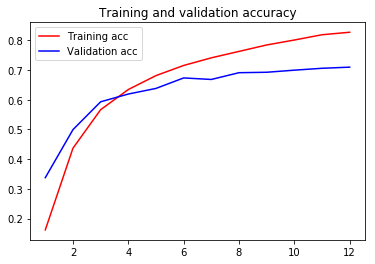

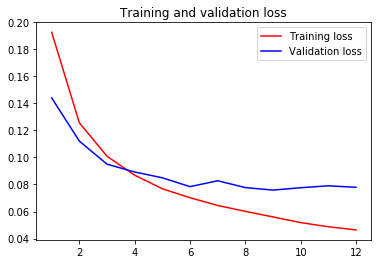

In [21]:
# Ref: https://stackoverflow.com/questions/63483337/how-can-i-plot-training-accuracy-training-loss-with-respect-to-epochs-in-tensor
import matplotlib.pyplot as plt

acc = model.history['acc']
val_acc = model.history['val_acc']
loss = model.history['loss']
val_loss = model.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Model-2 : Using 1D convolutions with character embedding

<pre>
<pre><img src="https://i.ytimg.com/vi/CNY8VjJt-iQ/maxresdefault.jpg" width="70%">
Here are the some papers based on Char-CNN
 1. Xiang Zhang, Junbo Zhao, Yann LeCun. <a href="http://arxiv.org/abs/1509.01626">Character-level Convolutional Networks for Text Classification</a>.NIPS 2015
 2. Yoon Kim, Yacine Jernite, David Sontag, Alexander M. Rush. <a href="https://arxiv.org/abs/1508.06615">Character-Aware Neural Language Models</a>. AAAI 2016
 3. Shaojie Bai, J. Zico Kolter, Vladlen Koltun. <a href="https://arxiv.org/pdf/1803.01271.pdf">An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling</a>
 4. Use the pratrained char embeddings <a href='https://github.com/minimaxir/char-embeddings/blob/master/glove.840B.300d-char.txt'>https://github.com/minimaxir/char-embeddings/blob/master/glove.840B.300d-char.txt</a>
</pre>

<img src='https://i.imgur.com/EuuoJtr.png'>

In [22]:
# Ref: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

# prepare tokenizer
token = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
token.fit_on_texts(X_train['Data Preprocessed'])

vocab_size = len(token.word_index) + 1

# integer encode the documents
encoded_docs_train = token.texts_to_sequences(X_train['Data Preprocessed'])
#print(encoded_docs_train)
encoded_docs_test = token.texts_to_sequences(X_test['Data Preprocessed'])
# print(encoded_docs_test)

# pad documents to the average length of documenents from the corpus
length = round((X_train['Data Preprocessed'].str.split().str.len()).mean())

padded_docs_train = pad_sequences(encoded_docs_train, maxlen = length, padding = 'post')
#print(padded_docs_train.shape)
padded_docs_test = pad_sequences(encoded_docs_test, maxlen = length, padding = 'post')
#print(padded_docs_test.shape)

In [23]:
# load the whole embedding into memory
embeddings_index = dict()
f = open(r'C:\Users\SVF\Downloads\glove.840B.300d-char\glove.840B.300d-char.txt', 'r', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 94 word vectors.


In [24]:
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in token.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [25]:
input = Input(shape=(length,))

embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False, input_length=length)(input)

conv_1 = Conv1D(filters=32, kernel_size=2, activation='relu')(embedding)
conv_2 = Conv1D(filters=30, kernel_size=2, activation='relu')(conv_1)

maxpool = MaxPool1D(pool_size=2, strides=1)(conv_2)

conv_3 = Conv1D(filters=32, kernel_size=2, activation='relu')(maxpool)
conv_4 = Conv1D(filters=30, kernel_size=2, activation='relu')(maxpool)

maxpool = MaxPool1D(pool_size=2, strides=1)(conv_4)

conv_5 = Conv1D(filters=32, kernel_size=2, activation='relu')(maxpool)

flatten = Flatten()(conv_5)

dropout = Dropout(rate=0.3)(flatten)

dense_1 = Dense(24, activation='relu', kernel_initializer=tf.keras.initializers.he_normal)(dropout)
dense_2 = Dense(24, activation='relu', kernel_initializer=tf.keras.initializers.he_normal)(dropout)
dense_3 = Dense(22, activation='relu', kernel_initializer=tf.keras.initializers.he_normal)(dropout)

concat = concatenate([dense_1, dense_2, dense_3])

output = Dense(20, activation='softmax')(concat)
                                                                                                                    
# Creating a model
model_1 = Model(inputs=input ,outputs=output)

earlystop = EarlyStopping(monitor='acc', patience=5, verbose=0.1)

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

filepath = "best_model_1.h5"
checkpoint = ModelCheckpoint(filepath,monitor='acc',verbose=1,mode='auto',save_best_only=True)

callback_list = [checkpoint, earlystop, tensorboard_callback]
optimizer = tf.keras.optimizers.Adam()

# Ref: https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score
model_1.compile(optimizer, loss='BinaryCrossentropy', metrics=['acc', tfa.metrics.F1Score(num_classes=20, average= 'micro')])


In [26]:
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 197)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 197, 300)     47020500    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 196, 32)      19232       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 195, 30)      1950        conv1d_7[0][0]                   
____________________________________________________________________________________________

In [27]:
model_1 = model_1.fit(padded_docs_train, y_train_ohe.todense(), epochs=35, batch_size=40, validation_data=(padded_docs_test, y_test_ohe.todense()),callbacks= callback_list)

Epoch 1/35
354/354 [==============================] - 33s 71ms/step - loss: 0.2136 - acc: 0.0581 - f1_score: 0.0591 - val_loss: 0.1985 - val_acc: 0.0652 - val_f1_score: 0.0652

Epoch 00001: acc improved from -inf to 0.05814, saving model to best_model_1.h5
Epoch 2/35
354/354 [==============================] - 18s 50ms/step - loss: 0.1980 - acc: 0.0646 - f1_score: 0.0646 - val_loss: 0.1976 - val_acc: 0.0697 - val_f1_score: 0.0697

Epoch 00002: acc improved from 0.05814 to 0.06458, saving model to best_model_1.h5
Epoch 3/35
354/354 [==============================] - 18s 50ms/step - loss: 0.1970 - acc: 0.0680 - f1_score: 0.0680 - val_loss: 0.1975 - val_acc: 0.0693 - val_f1_score: 0.0693

Epoch 00003: acc improved from 0.06458 to 0.06798, saving model to best_model_1.h5
Epoch 4/35
354/354 [==============================] - 18s 50ms/step - loss: 0.1964 - acc: 0.0693 - f1_score: 0.0693 - val_loss: 0.1970 - val_acc: 0.0686 - val_f1_score: 0.0686

Epoch 00004: acc improved from 0.06798 to 0.06

Epoch 35/35
354/354 [==============================] - 18s 50ms/step - loss: 0.1916 - acc: 0.0908 - f1_score: 0.0908 - val_loss: 0.1980 - val_acc: 0.0690 - val_f1_score: 0.0690

Epoch 00035: acc improved from 0.09029 to 0.09079, saving model to best_model_1.h5


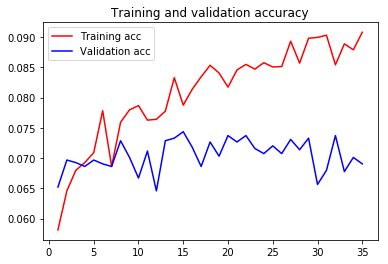

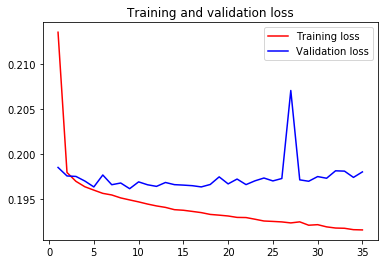

In [28]:
# Ref: https://stackoverflow.com/questions/63483337/how-can-i-plot-training-accuracy-training-loss-with-respect-to-epochs-in-tensor
import matplotlib.pyplot as plt

acc_1 = model_1.history['acc']
val_acc_1 = model_1.history['val_acc']
loss_1 = model_1.history['loss']
val_loss_1 = model_1.history['val_loss']

epochs = range(1, len(acc_1) + 1)

plt.plot(epochs, acc_1, 'r', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'r', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
table = PrettyTable(["Model", "Batch Size", "Accuracy"])
  
# Add rows
table.add_row(["Glove Word Embedding", "40", "0.82707"])
table.add_row(["Glove Character Embedding", "40", "0.0908"])

print(table)

+---------------------------+------------+----------+
|           Model           | Batch Size | Accuracy |
+---------------------------+------------+----------+
|    Glove Word Embedding   |     40     | 0.82707  |
| Glove Character Embedding |     40     |  0.0908  |
+---------------------------+------------+----------+
